In [1]:
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import linregress
import requests
import gmaps
import os
import warnings

# Import API key
from api_keys_p1 import g_key

from pprint import pprint

In [2]:
fire_file="Resources/FW_Veg_Rem_Combined.csv"
fire_df=pd.read_csv(fire_file)
fire_df.head()

,Unnamed: 0,Unnamed: 0.1,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,0,0,NaN,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,1,1,NaN,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,2,2,NaN,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,3,3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,4,4,NaN,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633


In [3]:
##Data Cleaning
#Gathering records from California, greater than or equal to 10 acres, and with valid weather data
fire_df=fire_df.loc[(fire_df["state"]=="CA")&
                    (fire_df["fire_size"]>=10)&
                    (fire_df["weather_file"]!="File Not Found")&
                    (fire_df["Temp_pre_30"]!=0)&
                    (fire_df["Temp_pre_15"]!=0)&
                    (fire_df["Temp_pre_7"]!=0)&
                    (fire_df["Temp_cont"]!=0)]

#dropping unneeded columns
fire_df=fire_df.drop(columns=["Unnamed: 0",
                              "Unnamed: 0.1",
                              "state",
                              "cont_clean_date",
                              "disc_date_final",
                              "cont_date_final",
                              "disc_date_pre",
                              "disc_pre_year",
                              "disc_pre_month",
                              "wstation_usaf",
                              "dstation_m",
                              "wstation_wban",
                              "wstation_byear",
                              "wstation_eyear",
                              "fire_mag",
                              "weather_file"])
# Drop NA
fire_df=fire_df.dropna()

# Drop duplicates
fire_df=fire_df.drop_duplicates(subset=["fire_name","latitude","longitude","fire_size"], keep = "first")

#renaming for aesthetics
fire_df=fire_df.rename(columns={"fire_name":"Fire Name",
                                "fire_size":"Fire Size",
                                "fire_size_class":"Fire Size Class",
                                "stat_cause_descr":"Fire Cause",
                                "latitude":"Latitude",
                                "longitude":"Longitude",
                                "disc_clean_date":"Date of Discovery",
                                "discovery_month":"Month of Discovery",
                                "putout_time":"Fire Duration",
                                "Temp_pre_30":"Temp 30 Days Prior",
                                "Temp_pre_15":"Temp 15 Days Prior",
                                "Temp_pre_7":"Temp 7 Days Prior",
                                "Temp_cont":"Temp on Containment",
                                "Wind_pre_30":"Wind 30 Days Prior",
                                "Wind_pre_15":"Wind 15 Days Prior",
                                "Wind_pre_7":"Wind 7 Days Prior",
                                "Wind_cont":"Wind on Containment",
                                "Hum_pre_30":"Humidity 30 Days Prior",
                                "Hum_pre_15":"Humidity 15 Days Prior",
                                "Hum_pre_7":"Humidity 7 Days Prior",
                                "Hum_cont":"Humidity on Containment",
                                "Prec_pre_30":"Precipitation 30 Days Prior",
                                "Prec_pre_15":"Precipitation 15 Days Prior",
                                "Prec_pre_7":"Precipitation 7 Days Prior",
                                "Prec_cont":"Precipitation on Containment",
                                "remoteness":"Remoteness"
})

In [4]:
#convert to farenheit
fire_df["Temp 30 Days Prior"]=(fire_df["Temp 30 Days Prior"] * 9/5) + 32
fire_df["Temp 15 Days Prior"]=(fire_df["Temp 15 Days Prior"] * 9/5) + 32
fire_df["Temp 7 Days Prior"]=(fire_df["Temp 7 Days Prior"] * 9/5) + 32
fire_df["Temp on Containment"]=(fire_df["Temp on Containment"] * 9/5) + 32

In [5]:
#making Fire Duration row float
fire_df['Fire Duration'] = fire_df['Fire Duration'].str.split(' ').str[0].astype("float")

In [6]:
#Creating Average dataframes based on Fire Class Size
class_size=fire_df.groupby("Fire Size Class")
wind_df=pd.DataFrame([class_size["Wind 30 Days Prior"].mean(),
                      class_size["Wind 15 Days Prior"].mean(),
                      class_size["Wind 7 Days Prior"].mean(),
                      class_size["Wind on Containment"].mean()]).T
wind_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

temp_df=pd.DataFrame([class_size["Temp 30 Days Prior"].mean(),
                      class_size["Temp 15 Days Prior"].mean(),
                      class_size["Temp 7 Days Prior"].mean(),
                      class_size["Temp on Containment"].mean()]).T
temp_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

hum_df=pd.DataFrame([class_size["Humidity 30 Days Prior"].mean(),
                      class_size["Humidity 15 Days Prior"].mean(),
                      class_size["Humidity 7 Days Prior"].mean(),
                      class_size["Humidity on Containment"].mean()]).T
hum_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]

prec_df=pd.DataFrame([class_size["Precipitation 30 Days Prior"].mean(),
                      class_size["Precipitation 15 Days Prior"].mean(),
                      class_size["Precipitation 7 Days Prior"].mean(),
                      class_size["Precipitation on Containment"].mean()]).T
prec_df["Fire Size Range"]=["11-100 Acres","100-250 Acres","251-1000 Acres","1001-5000 Acres",">5001 Acres"]



In [7]:
wind_df

,Wind 30 Days Prior,Wind 15 Days Prior,Wind 7 Days Prior,Wind on Containment,Fire Size Range
Fire Size Class,,,,,
C,2.795112,2.793418,2.714922,2.704893,11-100 Acres
D,3.145955,3.041723,3.038964,3.098255,100-250 Acres
E,2.949511,2.955312,2.923454,2.969513,251-1000 Acres
F,2.872330,2.813771,2.744824,2.754535,1001-5000 Acres
G,2.959979,2.920079,2.813630,2.919826,>5001 Acres


Text(0.5, 0, 'Wind (m/s)')

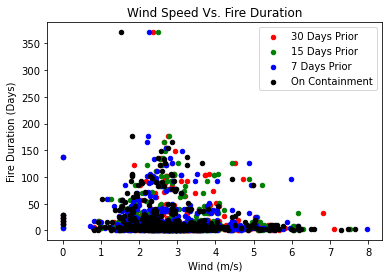

In [8]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 30 Days Prior', color='r',label='30 Days Prior',title="Wind Speed Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Wind 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Wind on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Wind (m/s)")

The r-squared is: 0.00662318675764658


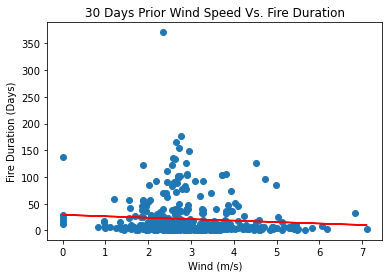

The r-squared is: 0.0034889796259942292


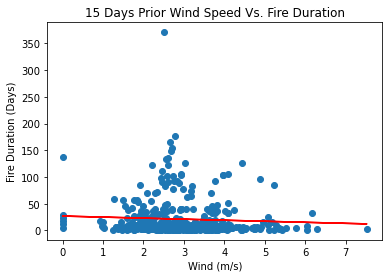

The r-squared is: 0.005554347905607397


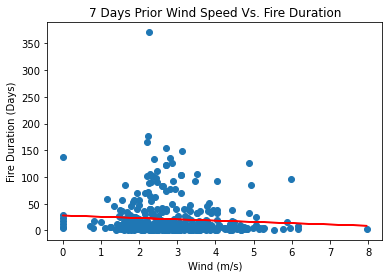

The r-squared is: 0.024099861900323916


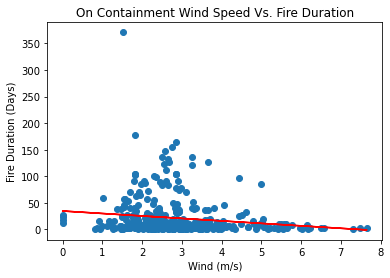

In [9]:
# Wind 30 Days Prior
x_30 = fire_df['Wind 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
#line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
#plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("30 Days Prior Wind Speed Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Wind 15 Days Prior
x_15 = fire_df['Wind 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
#line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
#plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("15 Days Prior Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Wind 7 Days Prior
x_7 = fire_df['Wind 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
#line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
#plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("7 Days Prior Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Wind on Containment
x_c = fire_df['Wind on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
#line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
#plt.annotate(line_eq,(3,200),fontsize=15,color="r")
plt.title("On Containment Wind Speed Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Wind (m/s)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

Text(0.5, 0, 'Wind (m/s)')

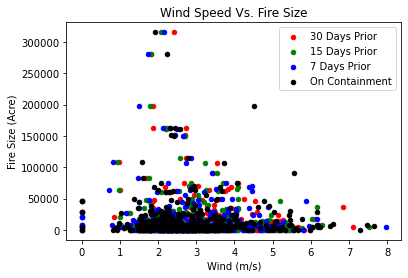

In [10]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 30 Days Prior', color='r',label='30 Days Prior',title="Wind Speed Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Wind 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Wind on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Wind (m/s)")

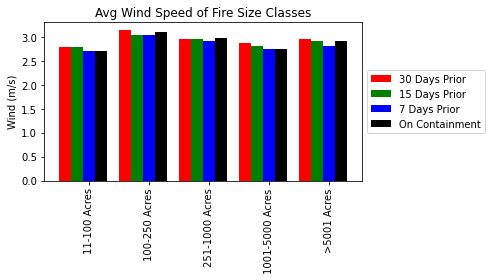

In [11]:
x = np.arange(len(wind_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,wind_df["Wind 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,wind_df["Wind 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,wind_df["Wind 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,wind_df["Wind on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Wind (m/s)')
ax.set_title('Avg Wind Speed of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Temp (F)')

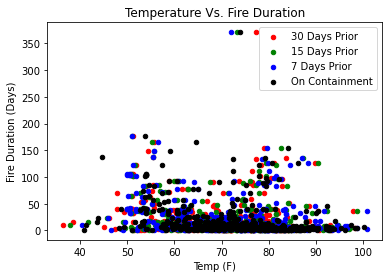

In [12]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 30 Days Prior', color='r',label='30 Days Prior',title="Temperature Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Temp 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Temp on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Temp (F)")

The r-squared is: 0.019936856693578326


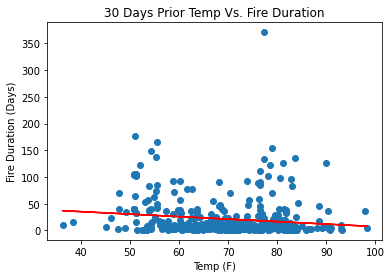

The r-squared is: 0.02247020275595791


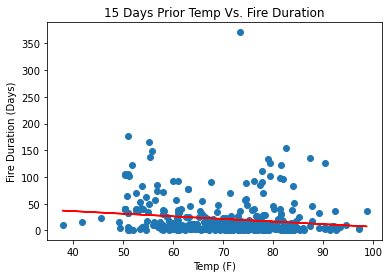

The r-squared is: 0.030933236798842818


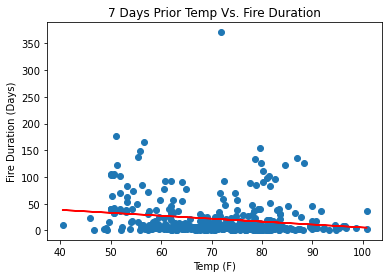

The r-squared is: 0.04843963965875056


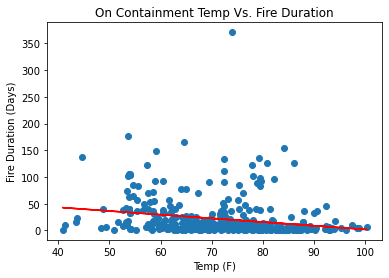

In [13]:
# Temp 30 Days Prior
x_30 = fire_df['Temp 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
#plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("30 Days Prior Temp Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Temp 15 Days Prior
x_15 = fire_df['Temp 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
#plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("15 Days Prior Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Temp 7 Days Prior
x_7 = fire_df['Temp 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
#plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("7 Days Prior Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Temp on Containment
x_c = fire_df['Temp on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
#plt.annotate(line_eq,(60,200),fontsize=15,color="r")
plt.title("On Containment Temp Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Temp (F)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

Text(0.5, 0, 'Temp (F)')

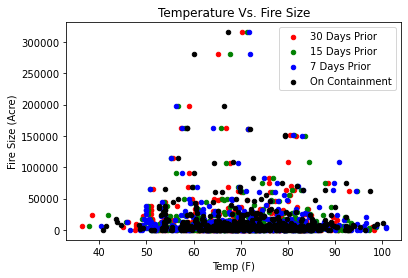

In [14]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 30 Days Prior', color='r',label='30 Days Prior',title="Temperature Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Temp 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Temp on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Temp (F)")

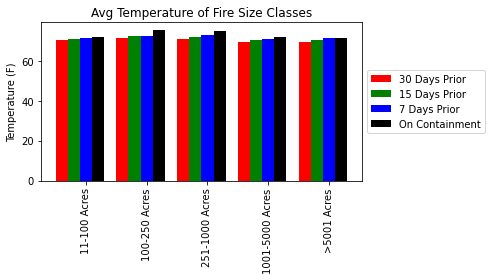

In [15]:
x = np.arange(len(temp_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,temp_df["Temp 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,temp_df["Temp 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,temp_df["Temp 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,temp_df["Temp on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Temperature (F)')
ax.set_title('Avg Temperature of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(temp_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Humidity (%)')

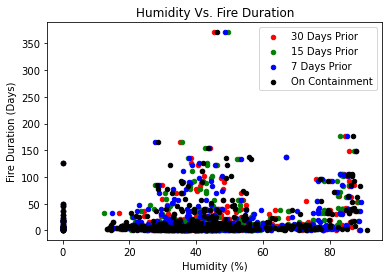

In [16]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 30 Days Prior', color='r',label='30 Days Prior',title="Humidity Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Humidity on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Humidity (%)")

The r-squared is: 0.024715039852194278


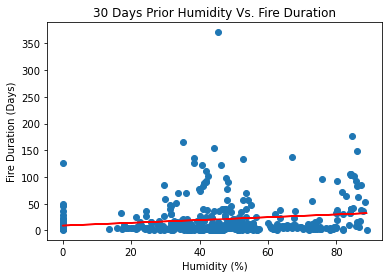

The r-squared is: 0.03061823883713554


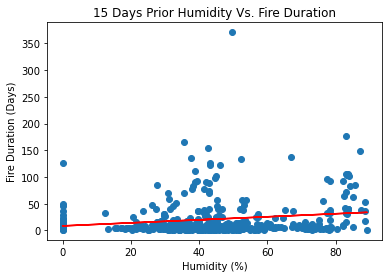

The r-squared is: 0.033997740885208155


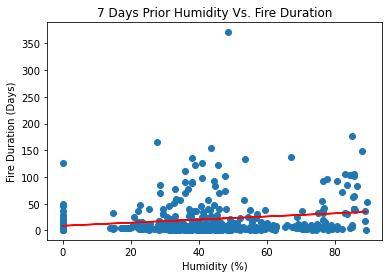

The r-squared is: 0.05249224458556723


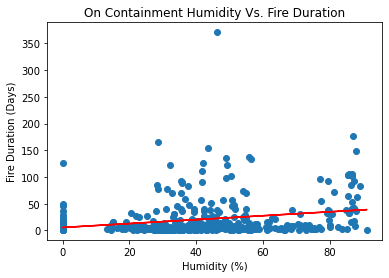

In [17]:
# Humidity 30 Days Prior
x_30 = fire_df['Humidity 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("30 Days Prior Humidity Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Humidity 15 Days Prior
x_15 = fire_df['Humidity 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("15 Days Prior Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Humidity 7 Days Prior
x_7 = fire_df['Humidity 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("7 Days Prior Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Humidity on Containment
x_c = fire_df['Humidity on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("On Containment Humidity Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Humidity (%)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

Text(0.5, 0, 'Humidity (%)')

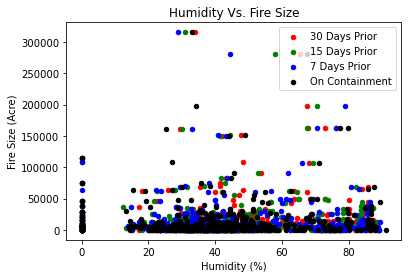

In [18]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 30 Days Prior', color='r',label='30 Days Prior',title="Humidity Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Humidity 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Humidity on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Humidity (%)")

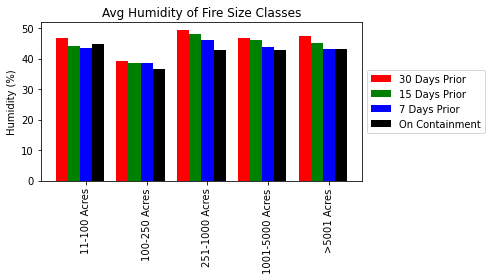

In [19]:
x = np.arange(len(hum_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,hum_df["Humidity 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,hum_df["Humidity 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,hum_df["Humidity 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,hum_df["Humidity on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Humidity (%)')
ax.set_title('Avg Humidity of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

Text(0.5, 0, 'Precipitation (mm)')

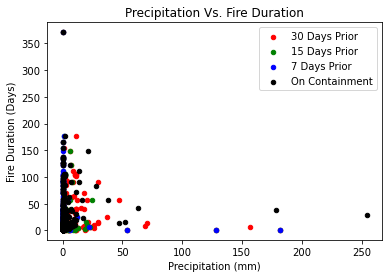

In [20]:
ax1 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 30 Days Prior', color='r',label='30 Days Prior',title="Precipitation Vs. Fire Duration")    
ax2 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Duration', x='Precipitation on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Duration (Days)")
ax1.set_xlabel("Precipitation (mm)")

The r-squared is: 1.5176402192938859e-05


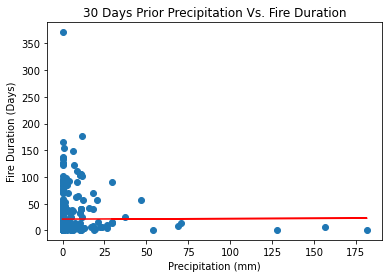

The r-squared is: 0.0010804493196030069


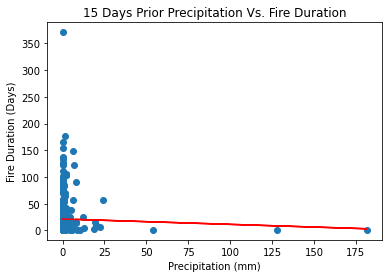

The r-squared is: 0.0019134142786484825


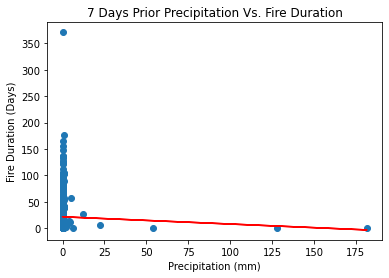

The r-squared is: 0.005345700603186718


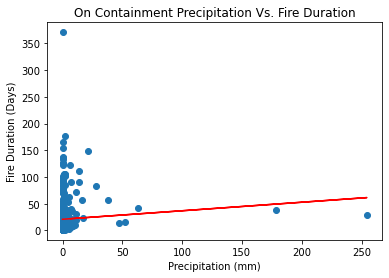

In [21]:
# Precipitation 30 Days Prior
x_30 = fire_df['Precipitation 30 Days Prior'].astype('float')
y_values = fire_df['Fire Duration'].astype('float')

# Plot scatter plot
plt.scatter(x_30,y_values)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_30,y_values)
regress_values = x_30 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot regression line
plt.plot(x_30,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("30 Days Prior Precipitation Vs. Fire Duration")

# Label plot
plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Precipitation 15 Days Prior
x_15 = fire_df['Precipitation 15 Days Prior'].astype('float')

plt.scatter(x_15,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_15,y_values)
regress_values = x_15 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_15,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("15 Days Prior Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Precipitation 7 Days Prior
x_7 = fire_df['Precipitation 7 Days Prior'].astype('float')

plt.scatter(x_7,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_7,y_values)
regress_values = x_7 * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_7,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("7 Days Prior Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Precipitation on Containment
x_c = fire_df['Precipitation on Containment'].astype('float')

plt.scatter(x_c,y_values)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_c,y_values)
regress_values = x_c * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_c,regress_values,"r-")
#plt.annotate(line_eq,(40,200),fontsize=15,color="r")
plt.title("On Containment Precipitation Vs. Fire Duration")

plt.ylabel("Fire Duration (Days)")
plt.xlabel("Precipitation (mm)")
print(f"The r-squared is: {rvalue**2}")
plt.show()

Text(0.5, 0, 'Precipitation (mm)')

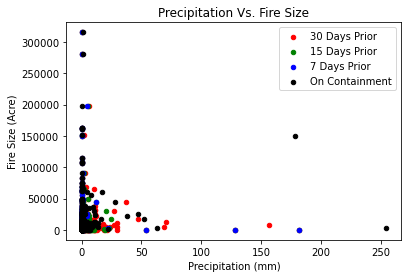

In [22]:
ax1 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 30 Days Prior', color='r',label='30 Days Prior',title="Precipitation Vs. Fire Size")    
ax2 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 15 Days Prior', color='g',label='15 Days Prior',ax=ax1)    
ax3 = fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation 7 Days Prior', color='b', label='7 Days Prior',ax=ax1)
ax4=fire_df.plot(kind='scatter', y='Fire Size', x='Precipitation on Containment', color='0',label='On Containment', ax=ax1)
ax1.set_ylabel("Fire Size (Acre)")
ax1.set_xlabel("Precipitation (mm)")

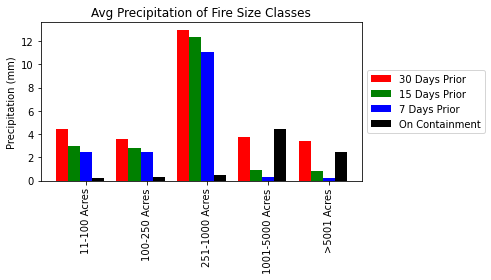

In [23]:
x = np.arange(len(prec_df.index))
width = .2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width,prec_df["Precipitation 30 Days Prior"],width, label="30 Days Prior",color="r")
rects2 = ax.bar(x - width,prec_df["Precipitation 15 Days Prior"],width, label="15 Days Prior", color='g')
rects3 = ax.bar(x,prec_df["Precipitation 7 Days Prior"],width, label="7 Days Prior", color='b')
rects4 = ax.bar(x+width,prec_df["Precipitation on Containment"],width, label="On Containment", color='0')
 
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Avg Precipitation of Fire Size Classes')
ax.set_xticks(x)
ax.set_xticklabels(wind_df["Fire Size Range"],rotation="90")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

In [24]:
# Configure gmaps
gmaps.configure(api_key=g_key)

In [25]:
# find out the center of map:
lat_m = fire_df.Latitude.mean()
lng_m = fire_df.Longitude.mean()
print(lat_m,lng_m)

37.345843161690816 -119.73906863961354


In [30]:
# Create a fire size Heatmap layer to the map

locations = fire_df[["Latitude","Longitude"]]

heatmap_layer = gmaps.heatmap_layer(locations, weights = fire_df["Fire Size"], 
                                    dissipating = False, max_intensity = float(fire_df["Fire Size"].max()), 
                                    point_radius = 0.5)
fig = gmaps.figure(center = (37.2,-119.9), zoom_level = 5.4, layout={'width': '400px', 'height': '600px'})

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='600px', width='400px'))

In [31]:
# Create symbol layer
symbol_layer = gmaps.symbol_layer(locations, fill_color='rgba(0, 150, 0, 0.4)',
                                  stroke_color='rgba(0, 0, 150, 0.4)', scale=2)
fig02 = gmaps.figure(center = (37.2,-119.9), zoom_level = 5.4, layout={'width': '400px', 'height': '600px'})
fig02.add_layer(symbol_layer)
fig02

Figure(layout=FigureLayout(height='600px', width='400px'))

In [32]:
import warnings
warnings.filterwarnings('ignore')

damage19_path = "Resources/2019_fire_damages.csv"
damage18_path = "Resources/2018_fire_damage.csv"
damage17_path = "Resources/2017_fire_damage.csv"
damage16_path = "Resources/2016_fire_damage.csv"
damage19_df = pd.read_csv(damage19_path)
damage18_df = pd.read_csv(damage18_path)
damage17_df = pd.read_csv(damage17_path)
damage16_df = pd.read_csv(damage16_path)

In [33]:
# clean dataframes
nine_df = damage19_df.drop(labels = [0, 13, 14, 24, 25], axis = 0)
eight_df = damage18_df.drop(labels = [0, 13, 14, 24, 25], axis = 0)
seven_df = damage17_df.drop(labels = [0, 13, 14, 24, 25], axis = 0)
six_df = damage16_df.drop(labels = [0, 13, 14, 24, 25], axis = 0)

In [34]:
# Compare damage of each county by year
# Add year column to each df and then get region, region total, and year
year19 = nine_df[['Region', 'Region Total']]
year19 = year19.rename(columns = {'Region Total':'2019 Region Total'})
year18 = eight_df['Region Total']
year17 = seven_df['Region Total']
year16 = six_df['Region Total']
year19['2018 Region Total'] = year18
year19['2017 Region Total'] = year17
year19['2016 Region Total'] = year16

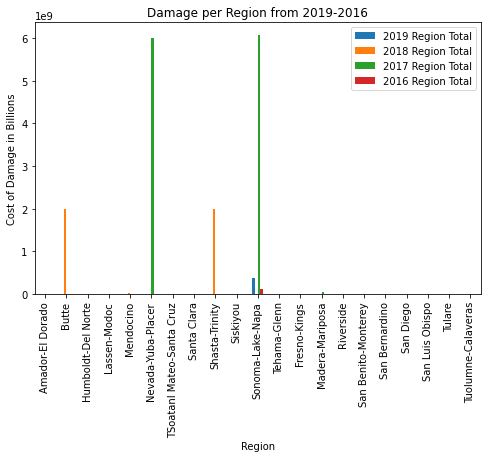

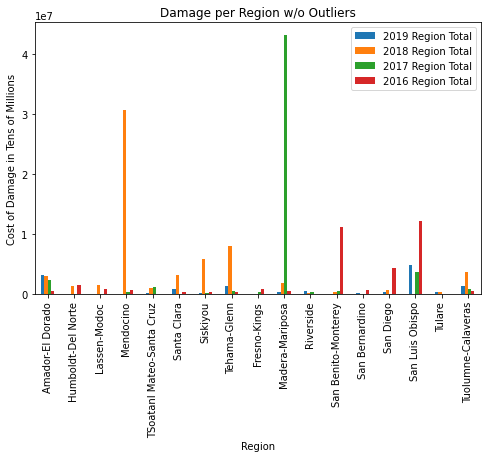

In [35]:
# plot
year19.plot(x="Region", y=["2019 Region Total", "2018 Region Total", "2017 Region Total",
                           "2016 Region Total"], kind="bar", figsize = (8, 5))
plt.title("Damage per Region from 2019-2016")
plt.xlabel("Region")
plt.ylabel("Cost of Damage in Billions")
plt.show()

# plot with no outliers
year19_normal = year19.drop(labels = [2, 6, 9, 11], axis = 0)
year19_normal.plot(x="Region", y=["2019 Region Total", "2018 Region Total", "2017 Region Total",
                           "2016 Region Total"], kind="bar", figsize = (8, 5))
plt.title("Damage per Region w/o Outliers")
plt.xlabel("Region")
plt.ylabel("Cost of Damage in Tens of Millions")
plt.show()

In [36]:
# Every year there seems to be a region that gets hit harder than other regions in terms of wildfire
# damage. However, the Sonoma-Lake-Napa region has cumulated enough costs to be featured three times
# in the first plot. Because the first plot shows costs in trillions versus the billions in the second,
# the fact that one region is shown three times makes it obvious that Sonoma is a hot spot for wildfires.
# Outliers for the second plot can be seen as specks in the first. The only other region where more than one
# bar is visible is Butte, which might be another region that could be susceptible to wildfires.

In [37]:
# Biggest Causes of Wildfire Damage

# make dataframe with cause totals
df1 = damage19_df.drop(columns = ['Region', 'Region Total'])
total_cause19 = pd.DataFrame(df1.loc[25,:])
total_cause19 = total_cause19.rename(columns = {25:'2019 State Total'})

df2 = damage18_df.drop(columns = ['Region', 'Region Total'])
total_cause18 = pd.DataFrame(df2.loc[25,:])
total_cause18 = total_cause18.rename(columns = {25:'2018 State Total'})

df3 = damage17_df.drop(columns = ['Region', 'Region Total'])
total_cause17 = pd.DataFrame(df3.loc[25,:])
total_cause17 = total_cause17.rename(columns = {25:'2017 State Total'})

df4 = damage16_df.drop(columns = ['Region', 'Region Total'])
total_cause16 = pd.DataFrame(df4.loc[25,:])
total_cause16 = total_cause16.rename(columns = {25:'2016 State Total'})

cause_damages = pd.concat([total_cause19, total_cause18, total_cause17, total_cause16], axis = 1)

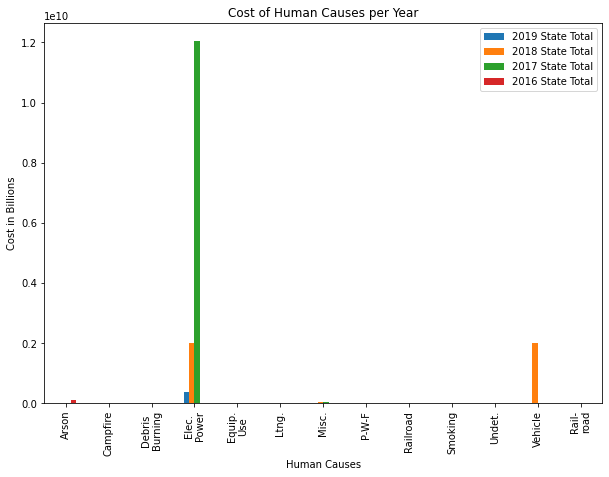

In [38]:
# plot
cause_damages.plot.bar(figsize = (10, 7))
plt.xlabel("Human Causes")
plt.ylabel("Cost in Billions")
plt.title("Cost of Human Causes per Year")
plt.show()

In [39]:
# This graph shows which human causes seem to cause the most wildfire damage from years 2019-2016. Obviously, electric power
# is the causes the most wildfire damage, with three years of electric power causing the most damage. The second would be
# from vehicular accidents. The third would be from either Arson or a miscellaneous cause. 

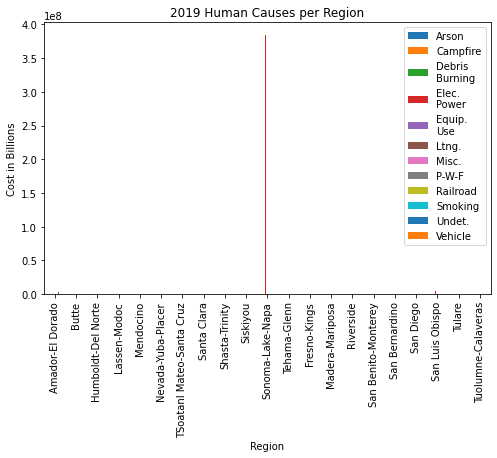

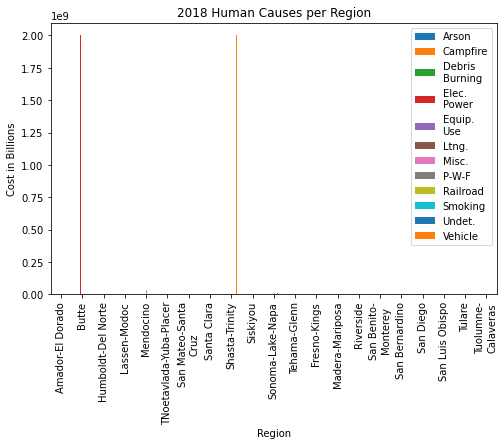

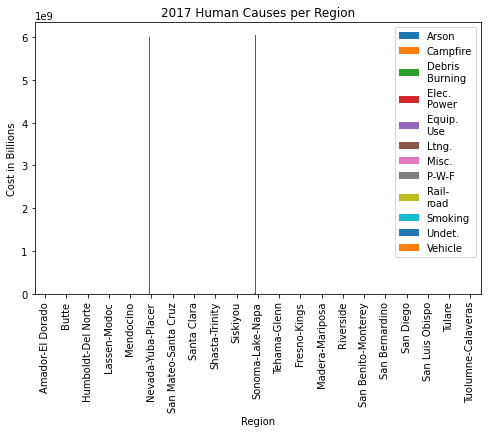

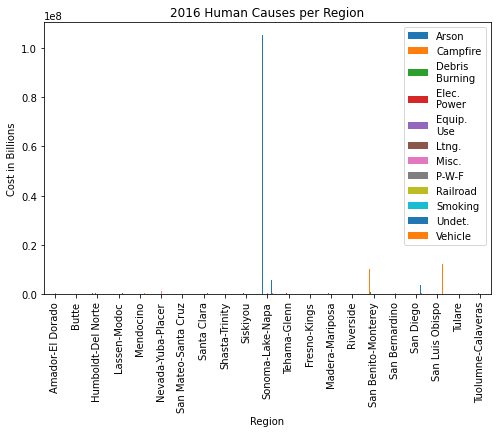

In [40]:
# Plot human causes per region
# 2019
nine_df2 = nine_df.drop(columns = ['Region Total'])
nine_df2.plot.bar(x = 'Region', figsize = (8, 5))
plt.xlabel("Region")
plt.ylabel("Cost in Billions")
plt.title("2019 Human Causes per Region")
plt.show()
# 2018
eight_df2 = eight_df.drop(columns = ['Region Total'])
eight_df2.plot.bar(x = 'Region', figsize = (8, 5))
plt.xlabel("Region")
plt.ylabel("Cost in Billions")
plt.title("2018 Human Causes per Region")
plt.show()
# 2017
seven_df2 = seven_df.drop(columns = ['Region Total'])
seven_df2.plot.bar(x = 'Region', figsize = (8, 5))
plt.xlabel("Region")
plt.ylabel("Cost in Billions")
plt.title("2017 Human Causes per Region")
plt.show()
# 2016
six_df2 = six_df.drop(columns = ['Region Total'])
six_df2.plot.bar(x = 'Region', figsize = (8, 5))
plt.xlabel("Region")
plt.ylabel("Cost in Billions")
plt.title("2016 Human Causes per Region")
plt.show()

In [41]:
# These sets of graphs show the major human causes per unit from 2019-2016. These graphs show similar
# results to the previous graphs: Sonoma-Lake-Napa seems to be the most common region for costly
# wildfires, with electric power, arson, and vehicular use being the top reasons for wildfires.

In [43]:
import seaborn as sns
from pandas import read_excel

In [45]:
# import sensor data
df=pd.read_csv("Resources/sensor9ab_for_project1.csv")
df.head()

,Unnamed: 0,created_at,entry_id,PM1.0_CF_ATM_ug.m3,PM2.5_CF_ATM_ug.m3,PM10.0_CF_ATM_ug.m3,UptimeMinutes,ADC,Temperature_F,Humidity_.
0,1,1/24/18 17:56,40,1.84,2.03,2.29,5,-79,79.0,15.0
1,2,1/24/18 17:58,42,1.95,2.08,2.08,8,-79,79.0,15.0
2,3,1/24/18 18:02,43,1.00,2.02,2.45,12,-78,80.0,14.0
3,4,1/24/18 18:04,44,0.95,1.11,1.82,13,-79,80.0,14.0
4,5,1/24/18 18:06,46,0.66,1.58,1.58,16,-82,80.0,14.0


In [46]:
data=df

#change the format of date and time column
data["created_at"] = pd.to_datetime(data["created_at"])#.dt.date

#change timezone from UTC to Los Angeles time
data["created_at"] = data["created_at"].dt.tz_localize("UTC").dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)


#November data
#subsetting the dataframe one week before and one week after the wildfire (November)
mask = (data['created_at'] > "2018-11-01") & (data['created_at'] <= "2018-11-20")
sub_data=data.loc[mask]

#remove the time part, leave only date
sub_data["created_at"] = pd.to_datetime(sub_data["created_at"]).dt.date
sub_data=sub_data.groupby("created_at").mean()


#compare data
#subsetting the dataframe of non-wildfire season (March)
mask = (data['created_at'] > "2018-03-01") & (data['created_at'] <= "2018-03-30")
sub_data2=data.loc[mask]

#remove the time part, leave only date, so can get the daily average PM2.5 concentration
sub_data2["created_at"] = pd.to_datetime(sub_data2["created_at"]).dt.date
sub_data2=sub_data2.groupby("created_at").mean()


sub_data.head(20)

,Unnamed: 0,entry_id,PM1.0_CF_ATM_ug.m3,PM2.5_CF_ATM_ug.m3,PM10.0_CF_ATM_ug.m3,UptimeMinutes,ADC,Temperature_F,Humidity_.
created_at,,,,,,,,,
2018-11-01,199622.0,300846.232915,12.933096,16.990809,18.176918,776.437936,-80.794979,75.008368,38.956764
2018-11-02,200328.5,301910.520115,13.732543,17.626724,18.755934,246.471264,-80.765805,77.491379,41.033046
2018-11-03,201025.5,302964.495702,19.415817,25.251361,26.738940,610.057307,-80.259312,76.408309,45.945559
2018-11-04,201736.0,304034.802213,26.321189,36.635934,39.173983,556.405256,-80.412172,74.550484,52.990318
2018-11-05,202444.5,305111.793948,22.593732,38.096671,43.298761,273.407781,-80.178674,74.301153,59.253602
2018-11-06,203129.0,306155.841481,10.307185,14.091037,15.227852,219.780741,-80.253333,74.964444,54.773333
2018-11-07,203807.5,307210.868035,13.193812,18.730279,20.069208,779.903226,-80.963343,73.020528,58.461877
2018-11-08,204501.0,308261.971631,18.338128,30.852440,34.492057,708.114894,-80.974468,73.551773,46.316312
2018-11-09,205208.0,309332.392102,6.005388,8.068011,8.803794,378.210155,-81.212976,75.039492,13.527504


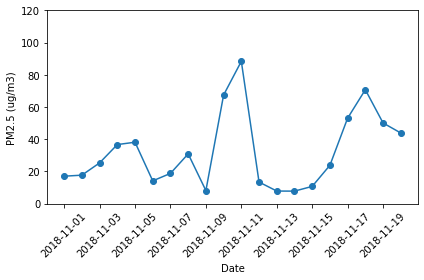

In [47]:
#plotting November line plot
sub_data=sub_data.dropna(how="any")
sub_data=sub_data.reset_index()

PM25_11 = sub_data['PM2.5_CF_ATM_ug.m3']
Date_11=sub_data["created_at"]


plt.plot(Date_11,PM25_11,marker="o")

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("PM2.5 (ug/m3)")
plt.ylim(0,120)
plt.tight_layout()
plt.savefig('air_nov.png',dpi=1000)

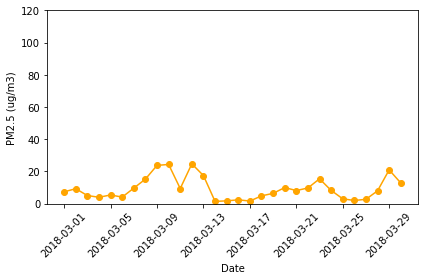

In [48]:
#plotting March line plot
sub_data2=sub_data2.dropna(how="any")
sub_data2=sub_data2.reset_index()

PM25_3 = sub_data2['PM2.5_CF_ATM_ug.m3']
Date_3=sub_data2["created_at"]
plt.plot(Date_3,PM25_3,color="orange",marker="o")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("PM2.5 (ug/m3)")
plt.ylim(0,120)

plt.tight_layout()
plt.savefig('air_mar.png',dpi=1000)